## Feature Selection

In [33]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import seaborn as sns

train_data = pd.read_csv("npf_train.csv")
train_data = train_data.drop(["id", "partlybad"], axis = 1)
class2 = np.array(["nonevent", "event"])
train_data.insert(1, "class2", class2[(train_data["class4"] != "nonevent").astype(int)])

In [34]:
import datetime

train_data["date"]

train_data["month"] = train_data["date"].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d").month)
train_data["month"].head()

0    1
1    2
2    3
3    3
4    4
Name: month, dtype: int64

Transform data by taking median

In [35]:
def transform_data(data):
    def mean_by_height(substring):
        return data.filter(like = substring).filter(like = ".mean").median(axis = 1)

    def std_by_height(substring):
        return data.filter(like = substring).filter(like = ".std").median(axis = 1)

    data = data.drop(["id", "partlybad"], axis = 1)
    class2 = np.array(["nonevent", "event"])
    data.insert(1, "class2", class2[(data["class4"] != "nonevent").astype(int)])
    data["month"] = train_data["date"].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d").month)

    new_data = pd.DataFrame()
    new_data[['date', 'class2', 'month']] = data[['date', 'class2', 'month']]
    new_data["CO.mean"] = mean_by_height("CO")
    new_data["CO.std"] = std_by_height("CO")
    new_data["H2O.mean"] = mean_by_height("H2O")
    new_data["H2O.std"] = std_by_height("H2O")
    new_data["RHIRGA.mean"] = mean_by_height("RHIRGA")
    new_data["RHIRGA.std"] = std_by_height("RHIRGA")
    new_data["NOx.mean"] = mean_by_height("NOx")
    new_data["NOx.std"] = std_by_height("NOx")
    new_data["NET.mean"] = mean_by_height("NET")
    new_data["NET.std"] = std_by_height("NET")
    new_data["NO.mean"] = data.iloc[:,27:39].filter(like = ".mean").median(axis = 1)
    new_data["NO.std"] = data.iloc[:,27:39].filter(like = ".std").median(axis = 1)
    new_data["O3.mean"] = data.iloc[:,51:61].filter(like = ".mean").median(axis = 1)
    new_data["O3.std"] = data.iloc[:, 51:61].filter(like = ".std").median(axis = 1)
    new_data[['Pamb0.mean', 'Pamb0.std', 'PAR.mean', 'PAR.std', 'PTG.mean', 'PTG.std', 'RGlob.mean', 'RGlob.std']] = data[['Pamb0.mean', 'Pamb0.std', 'PAR.mean', 'PAR.std', 'PTG.mean', 'PTG.std', 'RGlob.mean', 'RGlob.std']]
    new_data[['RPAR.mean', 'RPAR.std', 'SO2168.mean', 'SO2168.std', 'SWS.mean', 'SWS.std']] = data[['RPAR.mean', 'RPAR.std', 'SO2168.mean', 'SO2168.std', 'SWS.mean', 'SWS.std']]
    new_data["T.mean"] = data.filter(like = "T").iloc[:,4:].filter(like = ".mean").median(axis = 1)
    new_data["T.std"] = data.filter(like = "T").iloc[:,4:].filter(like = ".std").median(axis = 1)
    new_data[['UV_A.mean', 'UV_A.std', 'UV_B.mean', 'UV_B.std', 'CS.mean', 'CS.std', 'month']] = data[['UV_A.mean', 'UV_A.std', 'UV_B.mean', 'UV_B.std', 'CS.mean', 'CS.std', 'month']]
    new_data.set_index('date')

    return new_data

All feaures included

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

train_data = transform_data(pd.read_csv("npf_train.csv"))
test_data = transform_data(pd.read_csv("npf_test_hidden.csv"))

scaler = MinMaxScaler()
X = scaler.fit_transform(train_data.iloc[:,2:])
y = (train_data.iloc[:,1] == 'event').astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.75,random_state = 42, shuffle = True
)

In [37]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error


models = [
    DummyClassifier(strategy = "most_frequent"),
    LinearRegression(),
    LogisticRegression(), 
    LogisticRegression(penalty="l1", C=1/0.1, solver="saga"), 
    SVR(), 
    RandomForestClassifier()]

def loss(X_train, y_train, X_test, y_test, m):
    return mean_squared_error(y_test, m.fit(X_train, y_train).predict(X_test), squared = False)


res_all = pd.DataFrame(index = ["dummy", "linearreg", "logistic", "logistislasso", "SVR", "randomforest"])

res_all["test_mse"] = [loss(X_train, y_train, X_test, y_test, m) for m in models]


res_all['csv_mse'] = [
    -cross_val_score(
        m, X, y, cv = 10, scoring = "neg_root_mean_squared_error"
    ).mean()
    for m in models
]

phat = [m.fit(X_train, y_train).predict(X_test) for m in models]
accuracy = lambda p: (y_test * np.round(p) + (1 - y_test) * (1 - np.round(p))).mean()

res_all['accuracy'] = [accuracy(m.fit(X_train, y_train).predict(X_test)) for m in models]
res_all


/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: Conve

,test_mse,csv_mse,accuracy
dummy,0.709136,0.710100,0.497126
linearreg,0.415573,0.322133,0.867816
logistic,0.367502,0.339175,0.864943
logistislasso,0.330447,0.340603,0.890805
SVR,0.320852,0.301120,0.859195
randomforest,0.334767,0.366025,0.862069


### Correclation

In [38]:
Numeric_df = pd.DataFrame(train_data.iloc[:,2:])
Numeric_df['Y'] = y
corr= Numeric_df.corr()
corr_y = abs(corr["Y"])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

T.std          0.512896
UV_A.mean      0.515946
RHIRGA.std     0.529710
PAR.mean       0.549425
RGlob.mean     0.559735
RHIRGA.mean    0.624750
Y              1.000000
Name: Y, dtype: float64

Vistualise the highly correlated features

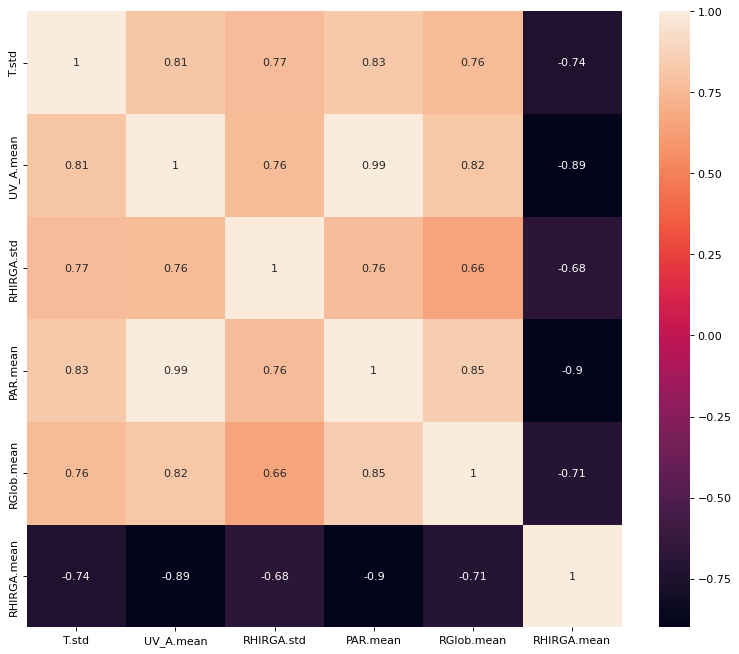

In [39]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

corr2 = Numeric_df[['T.std','UV_A.mean','RHIRGA.std','PAR.mean','RGlob.mean','RHIRGA.mean']].corr()

sns.heatmap(corr2, annot=True, fmt=".2g");

Only features with high correclation

In [40]:
#Using only the features that are highly correlated
train_data = transform_data(pd.read_csv("npf_train.csv"))
test_data = transform_data(pd.read_csv("npf_test_hidden.csv"))

scaler = MinMaxScaler()
X = scaler.fit_transform(train_data[['T.std','UV_A.mean','RHIRGA.std','PAR.mean','RGlob.mean','RHIRGA.mean']])
y = (train_data.iloc[:,1] == 'event').astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.75,random_state = 42, shuffle = True
)
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error


models = [
    DummyClassifier(strategy = "most_frequent"),
    LinearRegression(),
    LogisticRegression(), 
    LogisticRegression(penalty="l1", C=1/0.1, solver="saga"), 
    SVR(), 
    RandomForestClassifier()]

def loss(X_train, y_train, X_test, y_test, m):
    return mean_squared_error(y_test, m.fit(X_train, y_train).predict(X_test), squared = False)


res_correlated = pd.DataFrame(index = ["dummy", "linearreg", "logistic", "logistislasso", "SVR", "randomforest"])

res_correlated["test_mse"] = [loss(X_train, y_train, X_test, y_test, m) for m in models]


res_correlated['csv_mse'] = [
    -cross_val_score(
        m, X, y, cv = 10, scoring = "neg_root_mean_squared_error"
    ).mean()
    for m in models
]

phat = [m.fit(X_train, y_train).predict(X_test) for m in models]
accuracy = lambda p: (y_test * np.round(p) + (1 - y_test) * (1 - np.round(p))).mean()

res_correlated['accuracy'] = [accuracy(m.fit(X_train, y_train).predict(X_test)) for m in models]
res_correlated

/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: Conve

,test_mse,csv_mse,accuracy
dummy,0.709136,0.710100,0.497126
linearreg,0.356825,0.360178,0.847701
logistic,0.451689,0.417205,0.795977
logistislasso,0.408248,0.406510,0.833333
SVR,0.363242,0.365410,0.830460
randomforest,0.464238,0.443429,0.778736


Exclude the highly correlated features

In [41]:
#exclude the features that are highly correlated
train_data = transform_data(pd.read_csv("npf_train.csv"))
test_data = transform_data(pd.read_csv("npf_test_hidden.csv"))

scaler = MinMaxScaler()
X = scaler.fit_transform(train_data.drop(columns=['T.std','UV_A.mean','RHIRGA.std','PAR.mean','RGlob.mean','RHIRGA.mean']).iloc[:,2:])
y = (train_data.iloc[:,1] == 'event').astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.75,random_state = 42, shuffle = True
)
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error


models = [
    DummyClassifier(strategy = "most_frequent"),
    LinearRegression(),
    LogisticRegression(), 
    LogisticRegression(penalty="l1", C=1/0.1, solver="saga"), 
    SVR(), 
    RandomForestClassifier()]

def loss(X_train, y_train, X_test, y_test, m):
    return mean_squared_error(y_test, m.fit(X_train, y_train).predict(X_test), squared = False)


res_exCorrelated= pd.DataFrame(index = ["dummy", "linearreg", "logistic", "logistislasso", "SVR", "randomforest"])

res_exCorrelated["test_mse"] = [loss(X_train, y_train, X_test, y_test, m) for m in models]


res_exCorrelated['csv_mse'] = [
    -cross_val_score(
        m, X, y, cv = 10, scoring = "neg_root_mean_squared_error"
    ).mean()
    for m in models
]

phat = [m.fit(X_train, y_train).predict(X_test) for m in models]
accuracy = lambda p: (y_test * np.round(p) + (1 - y_test) * (1 - np.round(p))).mean()

res_exCorrelated['accuracy'] = [accuracy(m.fit(X_train, y_train).predict(X_test)) for m in models]
res_exCorrelated

/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: Conve

,test_mse,csv_mse,accuracy
dummy,0.709136,0.710100,0.497126
linearreg,0.418449,0.325319,0.873563
logistic,0.390255,0.367859,0.847701
logistislasso,0.367502,0.334995,0.864943
SVR,0.332323,0.303583,0.859195
randomforest,0.367502,0.370290,0.859195


### Random Forest

importance feature plot for random forest

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

train_data = transform_data(pd.read_csv("npf_train.csv"))
test_data = transform_data(pd.read_csv("npf_test_hidden.csv"))

scaler = MinMaxScaler()
X = scaler.fit_transform(train_data.iloc[:,2:])
y = (train_data.iloc[:,1] == 'event').astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.75,random_state = 42, shuffle = True
)

Accuracy of random forest: 0.864943


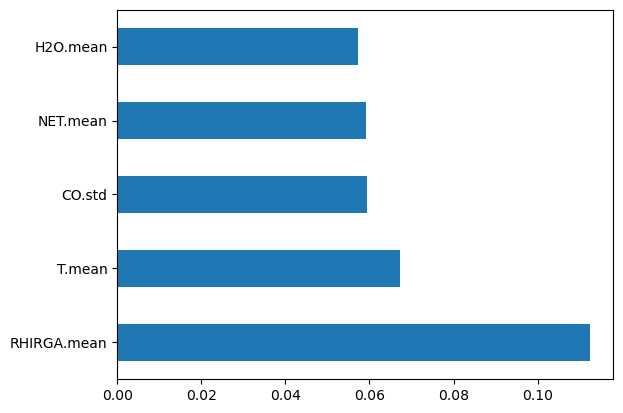

In [43]:
forest = RandomForestClassifier()
fitted_forest = forest.fit(X=X_train,y=y_train)
print('Accuracy of random forest: 0.864943')
importance_feature = pd.Series(forest.feature_importances_,index = train_data.columns[2:])
importance_feature.nlargest().plot(kind='barh');

Using only features that has >0.05 importance in Random forest

In [44]:
#Using only the features that has >0.05 importance in Random forest
scaler = MinMaxScaler()
new_X = scaler.fit_transform(train_data[['UV_A.mean','NET.mean','RHIRGA.mean','CO.std','H2O.mean']])

new_X_train, new_X_test, y_train, y_test = train_test_split(
    new_X, y, test_size = 0.75,random_state = 42, shuffle = True
)
accuracy(forest.fit(new_X_train, y_train).predict(new_X_test))

def loss(X_train, y_train, X_test, y_test, m):
    return mean_squared_error(y_test, m.fit(X_train, y_train).predict(X_test), squared = False)


res_randomForest = pd.DataFrame(index = ["randomforest","randomforest_afterFeatureSelection"])

res_randomForest["test_mse"] = [loss(X_train, y_train, X_test, y_test, forest),loss(new_X_train,y_train,new_X_test,y_test,forest)]

res_randomForest['csv_mse'] = [
    -cross_val_score(
        forest, X, y, cv = 10, scoring = "neg_root_mean_squared_error"
    ).mean(),
    -cross_val_score(
        forest, X, y, cv = 10, scoring = "neg_root_mean_squared_error"
    ).mean()
]

phat = [forest.fit(X_train, y_train).predict(X_test),forest.fit(new_X_train, y_train).predict(new_X_test)]
accuracy = lambda p: (y_test * np.round(p) + (1 - y_test) * (1 - np.round(p))).mean()

res_randomForest['accuracy'] = [accuracy(forest.fit(X_train, y_train).predict(X_test)),accuracy(forest.fit(new_X_train, y_train).predict(new_X_test))]
res_randomForest

,test_mse,csv_mse,accuracy
randomforest,0.371391,0.370860,0.864943
randomforest_afterFeatureSelection,0.386556,0.366724,0.847701


Using only features that has >0.05 importance in Random forest and apply to all other models

In [45]:
#using only feature that are important in randomforest
train_data = transform_data(pd.read_csv("npf_train.csv"))
test_data = transform_data(pd.read_csv("npf_test_hidden.csv"))

scaler = MinMaxScaler()
X = scaler.fit_transform(train_data[['UV_A.mean','NET.mean','RHIRGA.mean','CO.std','H2O.mean']])
y = (train_data.iloc[:,1] == 'event').astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.75,random_state = 42, shuffle = True
)
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error


models = [
    DummyClassifier(strategy = "most_frequent"),
    LinearRegression(),
    LogisticRegression(), 
    LogisticRegression(penalty="l1", C=1/0.1, solver="saga"), 
    SVR(), 
    RandomForestClassifier()]

def loss(X_train, y_train, X_test, y_test, m):
    return mean_squared_error(y_test, m.fit(X_train, y_train).predict(X_test), squared = False)


res = pd.DataFrame(index = ["dummy", "linearreg", "logistic", "logistislasso", "SVR", "randomforest"])

res["test_mse"] = [loss(X_train, y_train, X_test, y_test, m) for m in models]


res['csv_mse'] = [
    -cross_val_score(
        m, X, y, cv = 10, scoring = "neg_root_mean_squared_error"
    ).mean()
    for m in models
]

phat = [m.fit(X_train, y_train).predict(X_test) for m in models]
accuracy = lambda p: (y_test * np.round(p) + (1 - y_test) * (1 - np.round(p))).mean()

res['accuracy'] = [accuracy(m.fit(X_train, y_train).predict(X_test)) for m in models]
res

/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: Conve

,test_mse,csv_mse,accuracy
dummy,0.709136,0.710100,0.497126
linearreg,0.348855,0.349852,0.859195
logistic,0.401148,0.376305,0.839080
logistislasso,0.390255,0.390761,0.847701
SVR,0.333174,0.317665,0.847701
randomforest,0.379049,0.351909,0.841954


### Lassso CV

In [46]:
#LassoCV
train_data = transform_data(pd.read_csv("npf_train.csv"))
test_data = transform_data(pd.read_csv("npf_test_hidden.csv"))

scaler = MinMaxScaler()
X = scaler.fit_transform(train_data.iloc[:,2:])
y = (train_data.iloc[:,1] == 'event').astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.75,random_state = 42, shuffle = True
)

from sklearn.linear_model import LassoCV
regr = LogisticRegression(penalty="l1", C=1/0.1, solver="saga")
regr.fit(X_train,y_train)
print("LassoCV Model Accuracy: ", regr.score(X_test, y_test))
model_coef = pd.Series(regr.coef_[0], index = list(train_data.columns[2:]))
print("Variables Eliminated: ", str(sum(model_coef == 0)))
print("Variables Kept: ", str(sum(model_coef != 0)))

LassoCV Model Accuracy:  0.8908045977011494
Variables Eliminated:  9
Variables Kept:  28


/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Variables kept by lasso

In [47]:
variables_kept = (model_coef!=0).index

plot of importanc efeatures in lasso

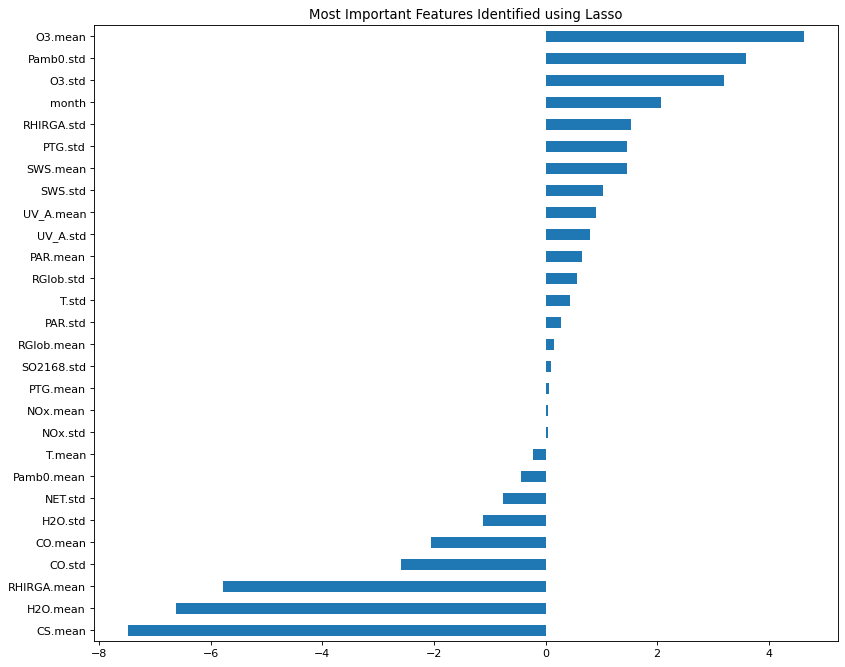

In [48]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

top_coef = model_coef.sort_values()
top_coef[top_coef != 0].plot(kind = "barh")
plt.title("Most Important Features Identified using Lasso");

In [49]:
#using only feature that are important in lasso(kept using in lasso)
train_data = transform_data(pd.read_csv("npf_train.csv"))
test_data = transform_data(pd.read_csv("npf_test_hidden.csv"))

scaler = MinMaxScaler()
X = scaler.fit_transform(train_data[variables_kept])
y = (train_data.iloc[:,1] == 'event').astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.75,random_state = 42, shuffle = True
)
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error


models = [
    DummyClassifier(strategy = "most_frequent"),
    LinearRegression(),
    LogisticRegression(), 
    LogisticRegression(penalty="l1", C=1/0.1, solver="saga"), 
    SVR(), 
    RandomForestClassifier()]

def loss(X_train, y_train, X_test, y_test, m):
    return mean_squared_error(y_test, m.fit(X_train, y_train).predict(X_test), squared = False)


res_lasso = pd.DataFrame(index = ["dummy", "linearreg", "logistic", "logistislasso", "SVR", "randomforest"])

res_lasso["test_mse"] = [loss(X_train, y_train, X_test, y_test, m) for m in models]


res_lasso['csv_mse'] = [
    -cross_val_score(
        m, X, y, cv = 10, scoring = "neg_root_mean_squared_error"
    ).mean()
    for m in models
]

phat = [m.fit(X_train, y_train).predict(X_test) for m in models]
accuracy = lambda p: (y_test * np.round(p) + (1 - y_test) * (1 - np.round(p))).mean()

res_lasso['accuracy'] = [accuracy(m.fit(X_train, y_train).predict(X_test)) for m in models]
res_lasso

/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: Conve

,test_mse,csv_mse,accuracy
dummy,0.709136,0.710100,0.497126
linearreg,0.415573,0.322133,0.867816
logistic,0.367502,0.339175,0.864943
logistislasso,0.330447,0.340603,0.890805
SVR,0.320852,0.301120,0.859195
randomforest,0.379049,0.363043,0.867816


Using lasvc for feature selection

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

train_data = transform_data(pd.read_csv("npf_train.csv"))
test_data = transform_data(pd.read_csv("npf_test_hidden.csv"))

scaler = MinMaxScaler()
X = scaler.fit_transform(train_data.iloc[:,2:])
y = (train_data.iloc[:,1] == 'event').astype(float)

#Do feature selection with
lsvc = LinearSVC(C = 0.1, penalty = 'l1', dual = False).fit(X,y)
model = SelectFromModel(lsvc, prefit=True)
X = model.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.75,random_state = 42, shuffle = True
)

In [51]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error


models = [
    DummyClassifier(strategy = "most_frequent"),
    LinearRegression(),
    LogisticRegression(), 
    LogisticRegression(penalty="l1", C=1/0.1, solver="saga"), 
    SVR(), 
    RandomForestClassifier()]

def loss(X_train, y_train, X_test, y_test, m):
    return mean_squared_error(y_test, m.fit(X_train, y_train).predict(X_test), squared = False)


res_lsvc = pd.DataFrame(index = ["dummy", "linearreg", "logistic", "logistislasso", "SVR", "randomforest"])

res_lsvc["test_mse"] = [loss(X_train, y_train, X_test, y_test, m) for m in models]


res_lsvc['csv_mse'] = [
    -cross_val_score(
        m, X, y, cv = 10, scoring = "neg_root_mean_squared_error"
    ).mean()
    for m in models
]

phat = [m.fit(X_train, y_train).predict(X_test) for m in models]
accuracy = lambda p: (y_test * np.round(p) + (1 - y_test) * (1 - np.round(p))).mean()

res_lsvc['accuracy'] = [accuracy(m.fit(X_train, y_train).predict(X_test)) for m in models]
res_lsvc


/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/laucheuk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: Conve

,test_mse,csv_mse,accuracy
dummy,0.709136,0.710100,0.497126
linearreg,0.304341,0.307116,0.905172
logistic,0.339032,0.325289,0.885057
logistislasso,0.288675,0.332637,0.913793
SVR,0.289747,0.289666,0.890805
randomforest,0.303239,0.349336,0.908046
